# Clustering

In [72]:
# %matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from hdbscan import HDBSCAN
# import shap

In [73]:
dateparse = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S%z")  # pd.datetime.strptime

core_users_to_cluster = pd.read_csv("../data/core_users_to_cluster.csv",
                    parse_dates=['created_at'],
                    converters={"user_id": str})

In [74]:
core_users_clustered = core_users_to_cluster.copy()

## Data preprocessing

Selezione delle features e standardizzazione dei dati.

In [75]:
# Seleziona le caratteristiche da utilizzare per il clustering
# all_features = ['nbr_followers', 'nbr_followings', 'nbr_liked_tweets', 'nbr_lists', 'nbr_tweets', 'nbr_usernames', 'following_ratio', 'followers_ratio', 'favorites_ratio', 'tweet_ratio']
all_features = ['nbr_liked_tweets', 'nbr_lists', 'nbr_tweets', 'nbr_usernames', 'nbr_followings', 'nbr_followers', 'favorites_ratio', 'followers_ratio', 'has_url', 'bio_sentences', 'bio_tokens', 'bio_characters', 'has_bio', 'account_age', 'following_ratio', 'tweet_ratio', 'retweet_ratio', 'reply_ratio', 'tweet_url_ratio', 'retweet_url_ratio', 'reply_url_ratio', 'words_in_tweets_median', 'unique_words_entropy', 'language_novelty', 'median_time_between_tweets', 'median_time_between_retweets', 'median_time_between_mentions', 'nbr_retweeted_accounts', 'nbr_domains_mean', 'median_words_count', 'median_char_count']

credibility_features = ['nbr_followings', 'nbr_followers', 'favorites_ratio', 'followers_ratio', 'has_url', 'bio_sentences', 'bio_tokens', 'bio_characters', 'has_bio', 'account_age', 'following_ratio', 'tweet_ratio']
initiative_features = ['retweet_ratio', 'reply_ratio', 'tweet_url_ratio', 'retweet_url_ratio', 'reply_url_ratio', 'words_in_tweets_median', 'unique_words_entropy']
adaptability_features = ['language_novelty', 'median_time_between_tweets', 'median_time_between_retweets', 'median_time_between_mentions', 'nbr_retweeted_accounts', 'nbr_domains_mean', 'median_words_count', 'median_char_count']

# Definisci i gruppi di features
feature_groups = {
    "All Features": all_features,
    "Credibility Features": credibility_features,
    "Initiative Features": initiative_features,
    "Adaptability Features": adaptability_features
}


# Standardizzazione delle features
core_users_standardized = (core_users_clustered[all_features] - core_users_clustered[all_features].mean()) / core_users_clustered[all_features].std()
# Normalizzazione delle features
# core_users_normalized = (core_users_clustering[all_features] - core_users_clustering[all_features].min()) / (core_users_clustering[all_features].max() - core_users_clustering[all_features].min())


# Sostituisci i valori mancanti con 0
core_users_standardized = core_users_standardized.fillna(0)

Calcolo della varianza spiegata cumulativa per determinare il numero di componenti da utilizzare per la PCA.

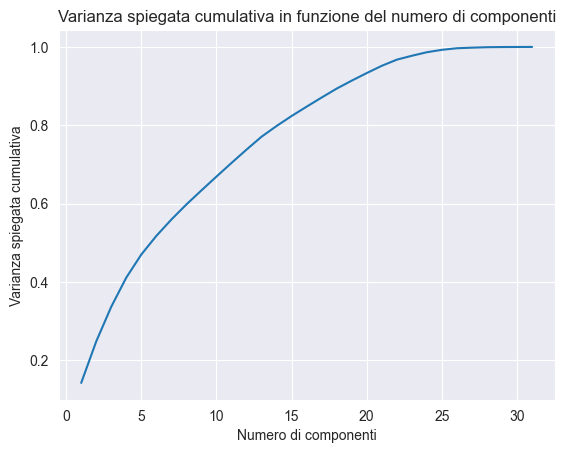

In [76]:
# PCA senza riduzione di dimensioni
pca = PCA()
core_users_pca = pca.fit(core_users_standardized)

# Calcola la varianza spiegata cumulativa
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Visualizza la varianza spiegata cumulativa
plt.plot(range(1,len(explained_variance)+1), explained_variance)
plt.title('Varianza spiegata cumulativa in funzione del numero di componenti')
plt.xlabel('Numero di componenti')
plt.ylabel('Varianza spiegata cumulativa')
plt.show()


# pca_calculation = [core_users_standardized_all, core_users_standardized_credibility, core_users_standardized_initiative, core_users_standardized_adaptability]
# core_users_pca = []
# 
# for i in range(len(pca_calculation)):
#     pca = PCA()
#     core_users_pca.append(pca.fit(pca_calculation[i]))
# 
#     # Calcola la varianza spiegata cumulativa
#     explained_variance = np.cumsum(pca.explained_variance_ratio_)
# 
#     # Visualizza la varianza spiegata cumulativa
#     plt.plot(range(1,len(explained_variance)+1), explained_variance)
#     plt.title('Varianza spiegata cumulativa in funzione del numero di componenti')
#     plt.xlabel('Numero di componenti')
#     plt.ylabel('Varianza spiegata cumulativa')
#     plt.show()
    

Applicazione della PCA per ridurre le dimensioni del dataset e utilizzo dell'Eblow Method per determinare il numero di cluster da utilizzare.

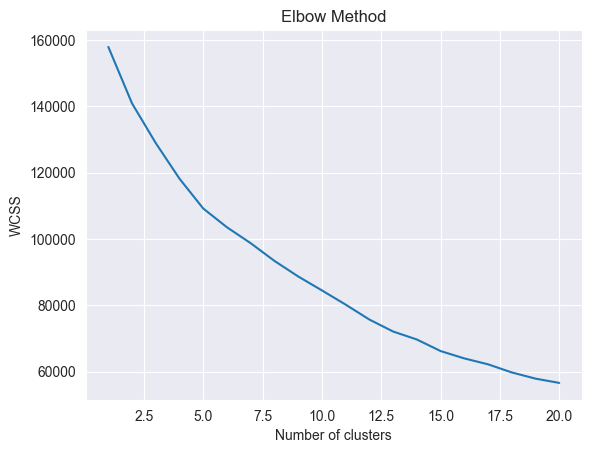

In [77]:
# Applica PCA
pca = PCA(n_components=14)
core_users_pca = pca.fit_transform(core_users_standardized)

# Calcola la WCSS per diverse quantità di cluster
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=0).fit(core_users_pca)
    wcss.append(kmeans.inertia_)

# Visualizza la WCSS in funzione del numero di cluster
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



# wcss_calculation = [core_users_standardized_all, core_users_standardized_credibility, core_users_standardized_initiative, core_users_standardized_adaptability]
# core_users_pca = []
# n_components = [2, 2, 2, 2]
# 
# for i in range(len(wcss_calculation)):
#     # Applica PCA
#     pca = PCA(n_components=n_components[i])
#     current_pca = pca.fit_transform(wcss_calculation[i])
#     core_users_pca.append(current_pca)  # Salva la matrice PCA nella lista
# 
#     # Calcola la WCSS per diverse quantità di cluster
#     wcss = []
#     for j in range(1, 21):
#         kmeans = KMeans(n_clusters=j, n_init=20, random_state=0).fit(current_pca)
#         wcss.append(kmeans.inertia_)
# 
#     # Visualizza la WCSS in funzione del numero di cluster
#     plt.plot(range(1, 21), wcss)
#     plt.title('Elbow Method')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('WCSS')
#     plt.show()

## K-Means algorithm

C:\Users\davis\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


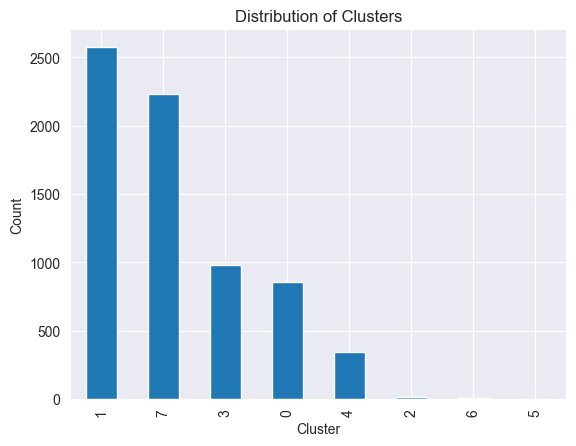

In [78]:
# Esegui il clustering K-means
kmeans = KMeans(n_clusters=8, random_state=0).fit(core_users_pca)

# Aggiungi le etichette dei cluster ai dati
core_users_clustered['kmeans_cluster'] = kmeans.labels_

# Visualizza la distribuzione dei cluster
core_users_clustered['kmeans_cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show()



# n_clusters = [5, 5, 4, 5]
# labels = ['all', 'credibility', 'initiative', 'adaptability']
# 
# for i in range(len(core_users_pca)):
#     # Esegui il clustering K-means
#     kmeans = KMeans(n_clusters=n_clusters[i], random_state=0).fit(core_users_pca[i])
#     
#     # Crea il nome della colonna dinamicamente
#     column_name = 'kmeans_cluster_' + labels[i]
# 
#     # Aggiungi le etichette dei cluster ai dati
#     core_users_clustered[column_name] = kmeans.labels_
# 
#     # Visualizza la distribuzione dei cluster
#     core_users_clustered[column_name].value_counts().plot(kind='bar')
#     plt.xlabel('Cluster')
#     plt.ylabel('Count')
#     plt.title('Distribution of Clusters for ' + labels[i])
#     plt.show()


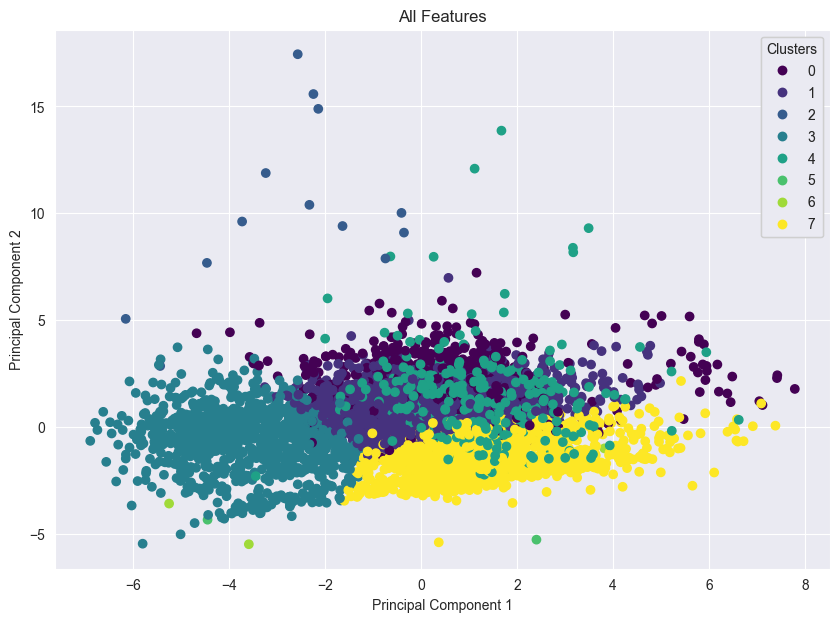

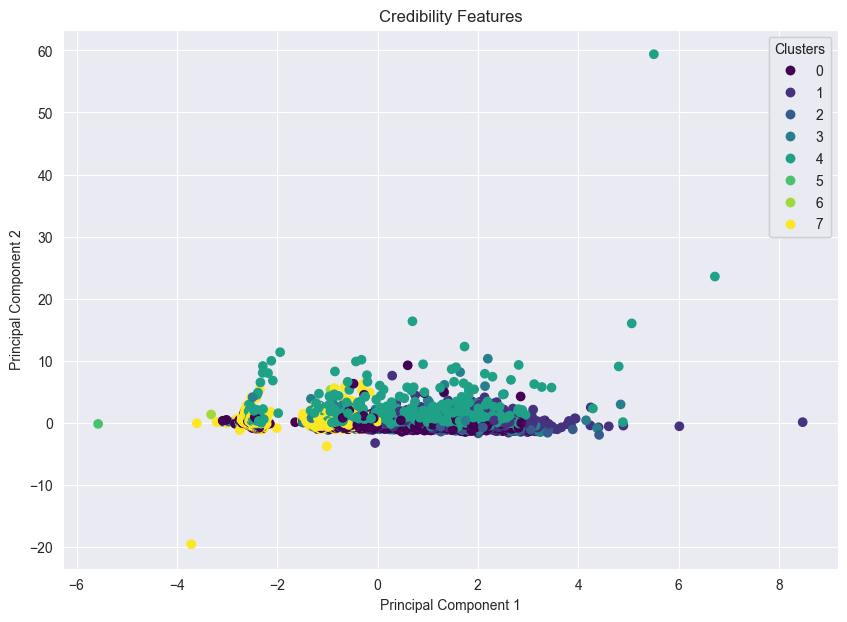

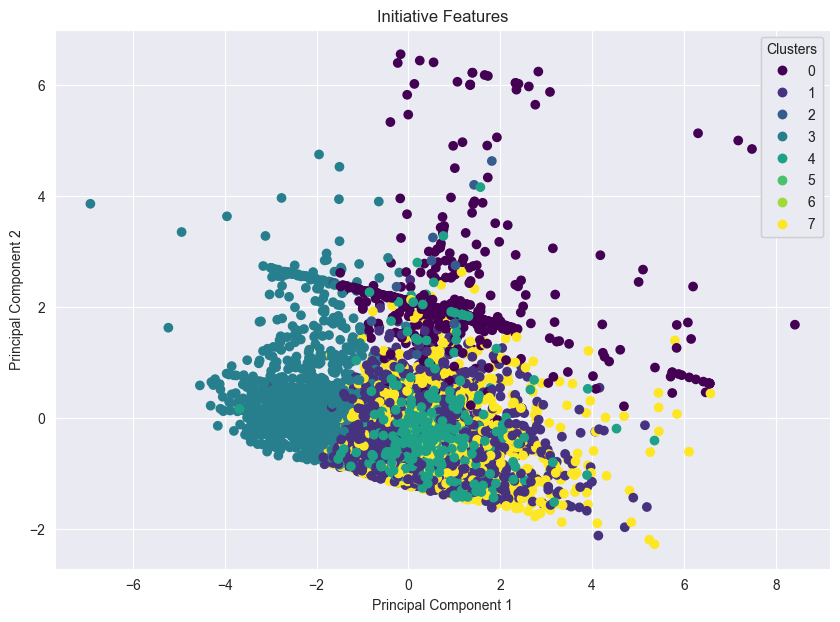

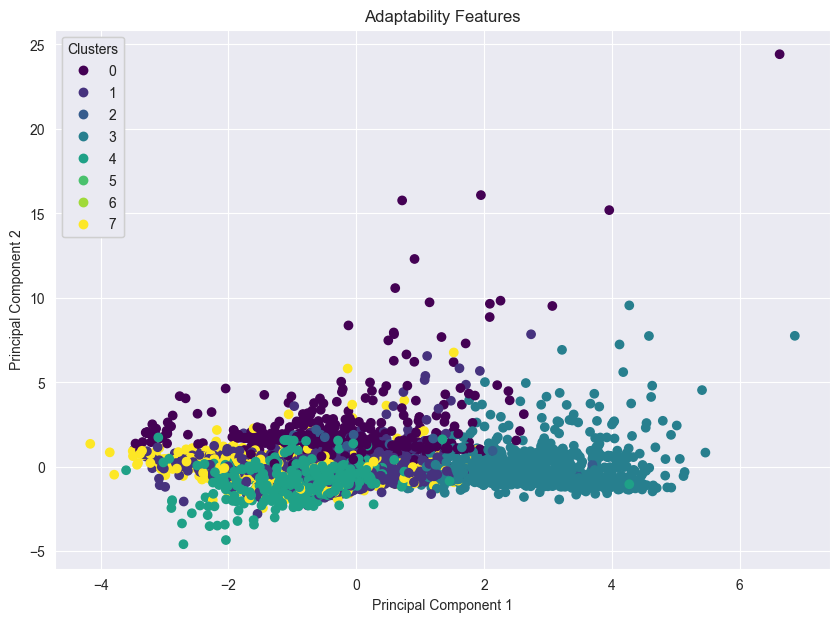

In [79]:
def plot_2D_PCA(data, labels, title):
    """Visualizza uno scatter plot 2D dei dati PCA"""    
    plt.figure(figsize=(10, 7))
    
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    
    plt.title(title)
    plt.show()

# Per ogni gruppo di feature
for title, features in feature_groups.items():
    subset = core_users_standardized[features]

    # Applica PCA con 2 componenti
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(subset)

    # Visualizza lo scatter plot
    plot_2D_PCA(pca_result, core_users_clustered['kmeans_cluster'].values, title)


## DBSCAN algorithm

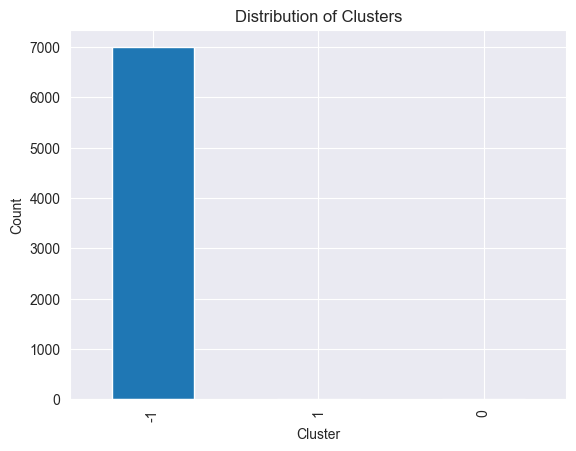

In [80]:
# Eseguiamo DBSCAN sui dati
db = DBSCAN(eps=0.4, min_samples=8).fit(core_users_pca)

# Aggiungi le etichette dei cluster ai dati
core_users_clustered['db_cluster'] = db.labels_

# Visualizza la distribuzione dei cluster
core_users_clustered['db_cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show()



# labels = ['all', 'credibility', 'initiative', 'adaptability']
# 
# for i in range(len(core_users_pca)):
#     # Eseguiamo DBSCAN sui dati
#     db = DBSCAN(eps=0.3, min_samples=8).fit(core_users_pca[i])
#     
#     # Crea il nome della colonna dinamicamente
#     column_name = 'db_cluster_' + labels[i]
#     
#     # Aggiungi le etichette dei cluster ai dati
#     core_users_clustered[column_name] = db.labels_
#     
#     # Visualizza la distribuzione dei cluster
#     core_users_clustered[column_name].value_counts().plot(kind='bar')
#     plt.xlabel('Cluster')
#     plt.ylabel('Count')
#     plt.title('Distribution of Clusters')
#     plt.show()


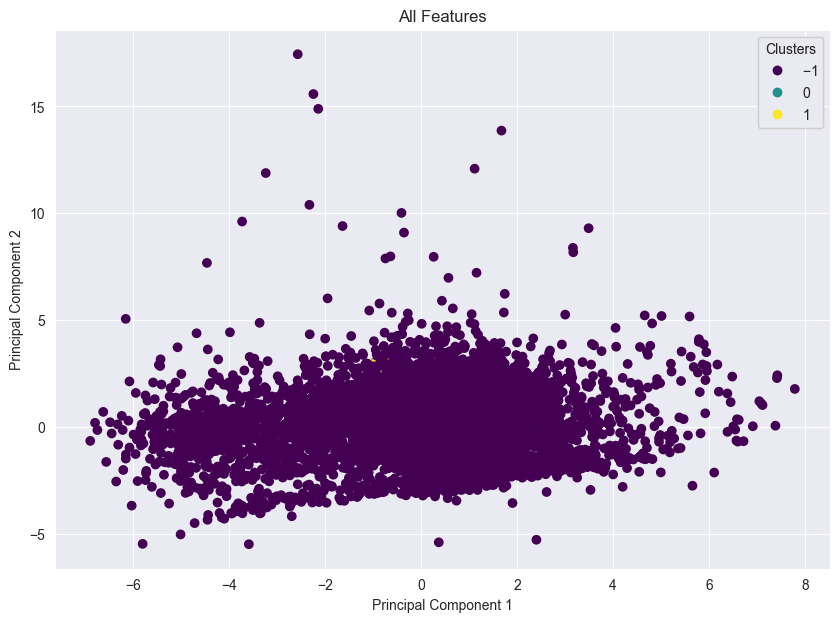

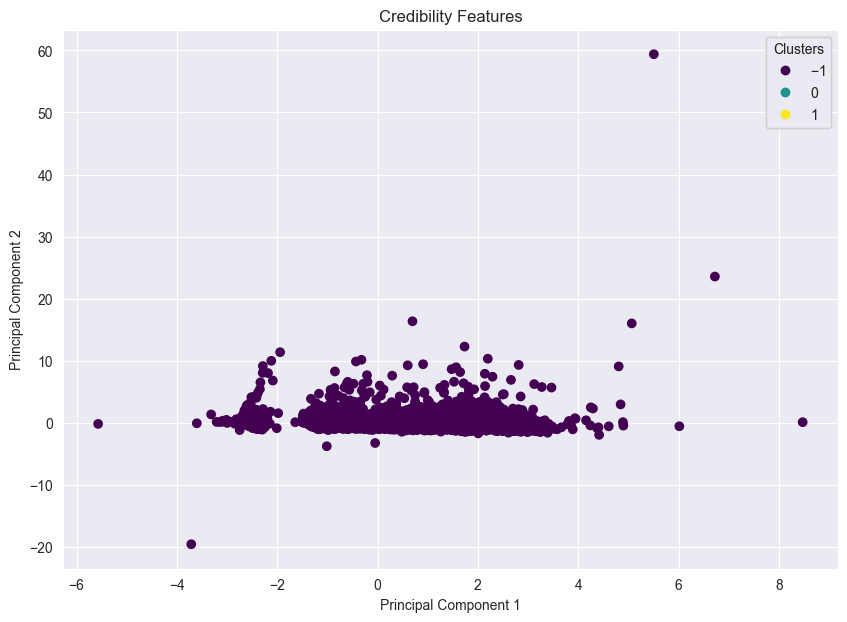

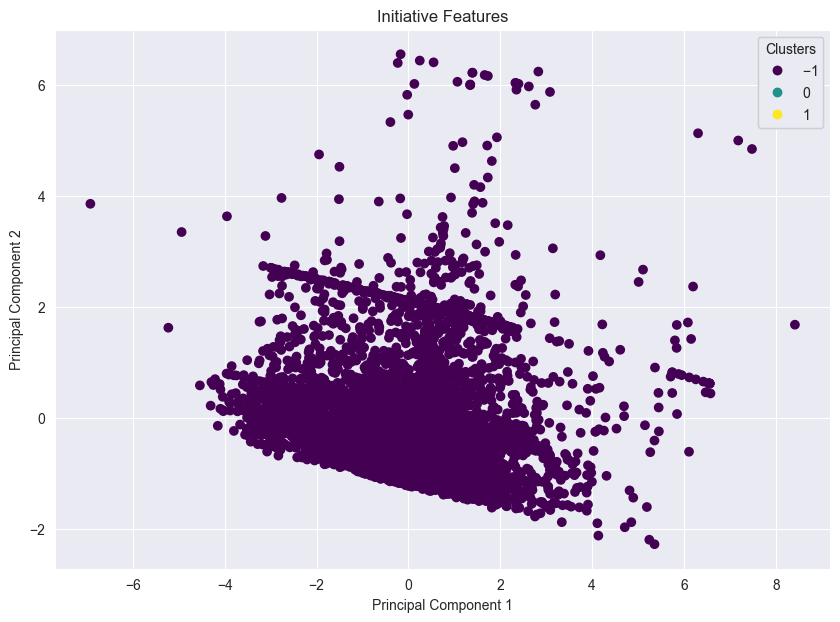

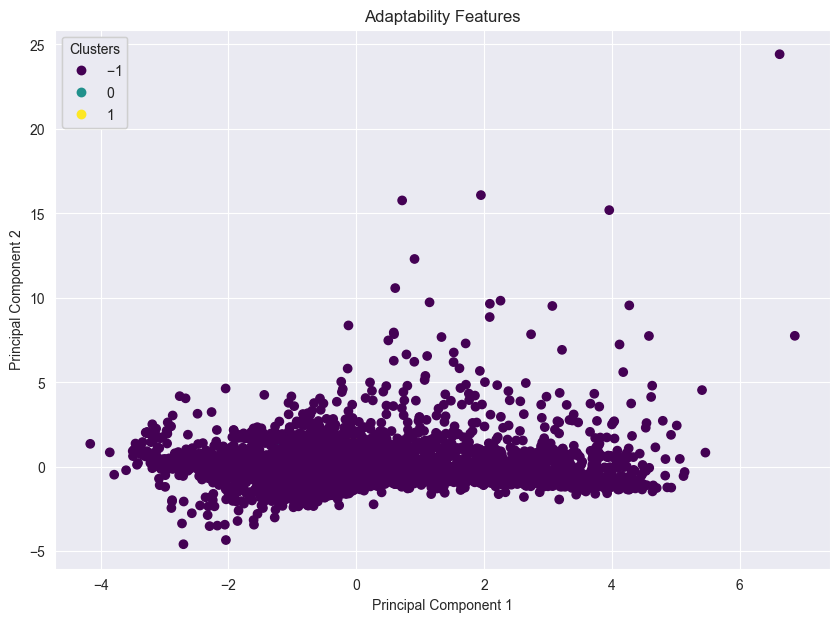

In [81]:
def plot_2D_PCA(data, labels, title):
    """Visualizza uno scatter plot 2D dei dati PCA"""    
    plt.figure(figsize=(10, 7))
    
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    
    plt.title(title)
    plt.show()

# Per ogni gruppo di feature
for title, features in feature_groups.items():
    subset = core_users_standardized[features]

    # Applica PCA con 2 componenti
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(subset)

    # Visualizza lo scatter plot
    plot_2D_PCA(pca_result, core_users_clustered['db_cluster'].values, title)


## HDBSCAN algorithm

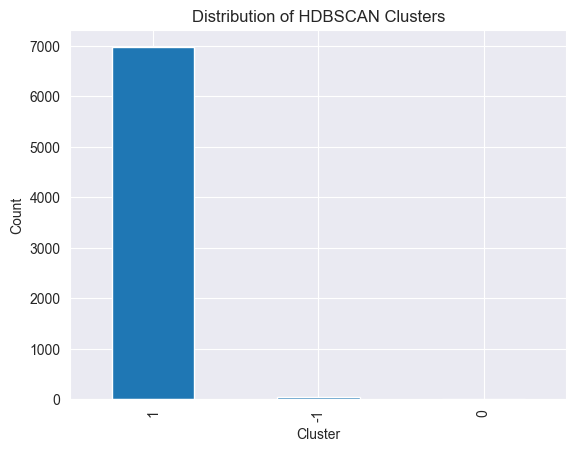

In [82]:
# Creiamo l'istanza di HDBSCAN
hdbscan = HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)

# Facciamo il fit su core_users_pca[0]
hdbscan_labels = hdbscan.fit_predict(core_users_pca)

# Aggiungiamo le etichette dei cluster ai dati
core_users_clustered['hdbscan_cluster'] = hdbscan_labels


# Visualizza la distribuzione dei cluster HDBSCAN
core_users_clustered['hdbscan_cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of HDBSCAN Clusters')
plt.show()



# labels = ['all', 'credibility', 'initiative', 'adaptability']
# 
# for i in range(len(core_users_pca)):
#     # Eseguiamo DBSCAN sui dati
#     hdbscan = HDBSCAN(min_cluster_size=5, gen_min_span_tree=True).fit(core_users_pca[i])
#     
#     # Crea il nome della colonna dinamicamente
#     column_name = 'hdbscan_cluster_' + labels[i]
#     
#     # Aggiungi le etichette dei cluster ai dati
#     core_users_clustered[column_name] = hdbscan.labels_
#     
#     # Visualizza la distribuzione dei cluster
#     core_users_clustered[column_name].value_counts().plot(kind='bar')
#     plt.xlabel('Cluster')
#     plt.ylabel('Count')
#     plt.title('Distribution of Clusters')
#     plt.show()


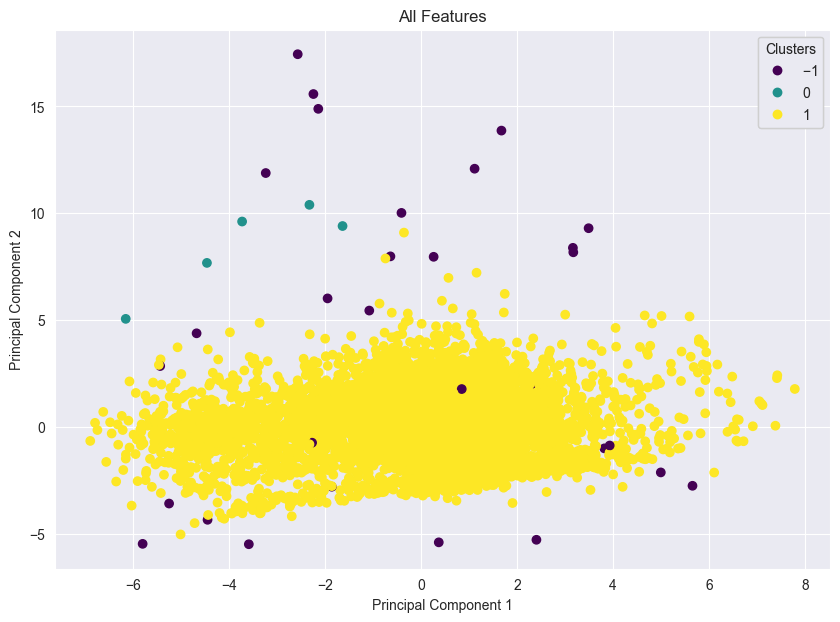

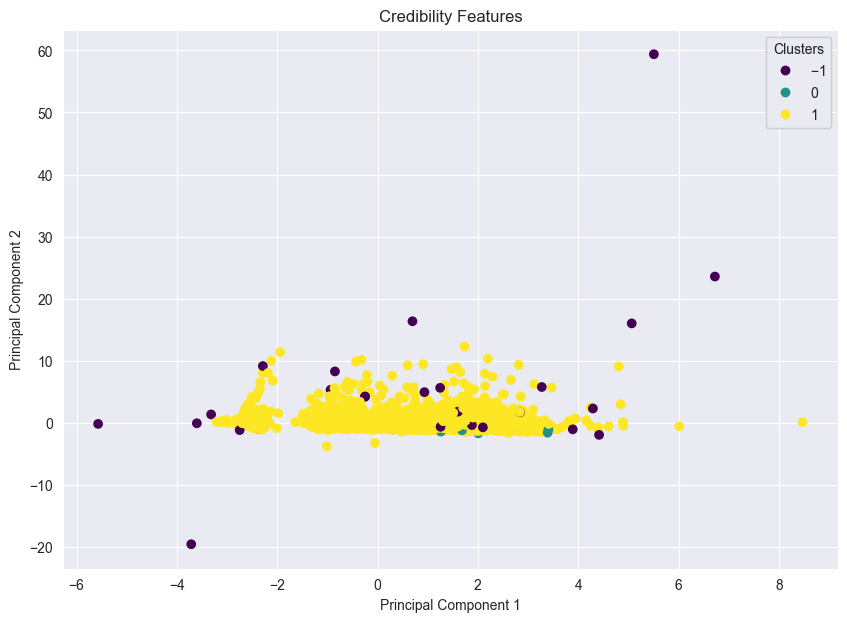

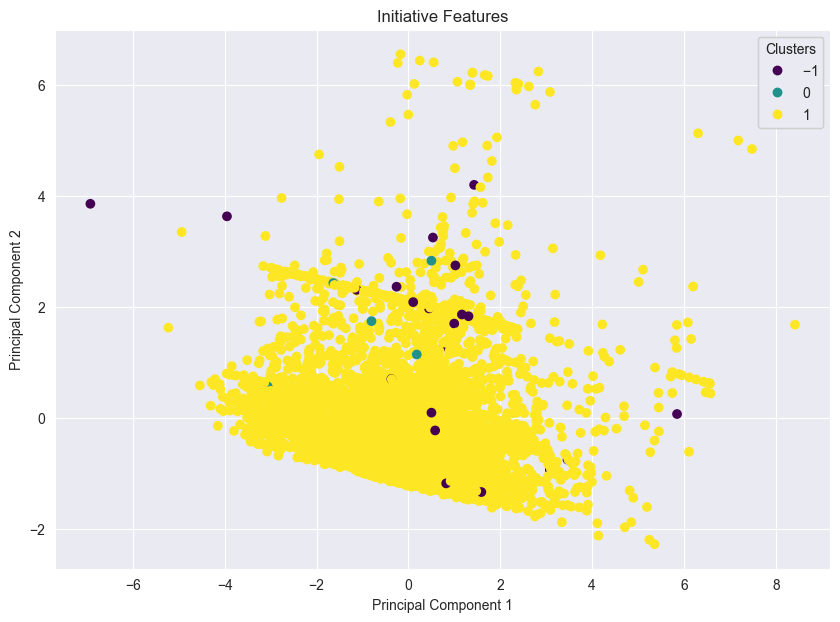

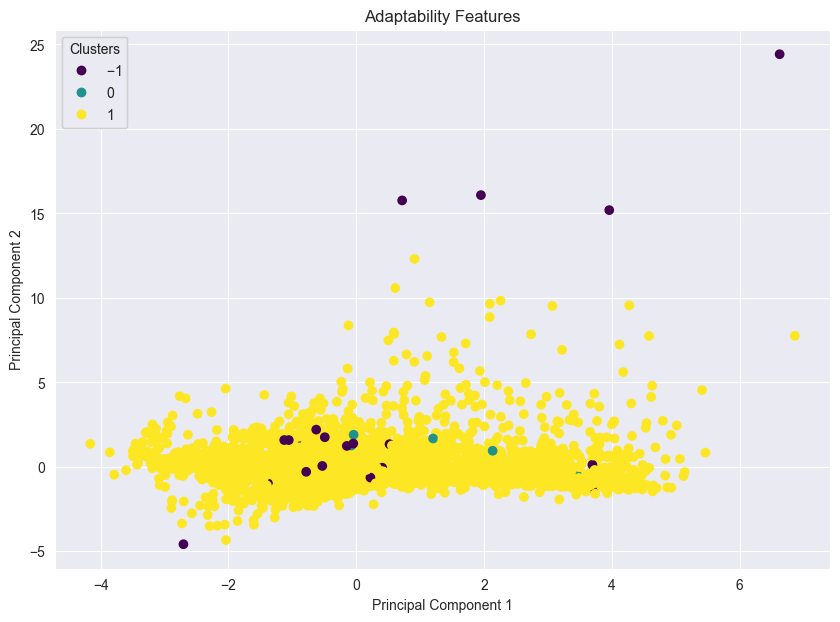

In [83]:
def plot_2D_PCA(data, labels, title):
    """Visualizza uno scatter plot 2D dei dati PCA"""    
    plt.figure(figsize=(10, 7))
    
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    
    plt.title(title)
    plt.show()

# Per ogni gruppo di feature
for title, features in feature_groups.items():
    subset = core_users_standardized[features]

    # Applica PCA con 2 componenti
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(subset)

    # Visualizza lo scatter plot
    plot_2D_PCA(pca_result, core_users_clustered['hdbscan_cluster'].values, title)


## Data Saving

In [84]:
core_users_clustered.to_csv('../data/core_users_clustered.csv', index=False)

## Random Forest Classifier

In [ ]:
# Creazione e addestramento del modello
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(core_users_standardized, core_users_clustered['kmeans_cluster'])


# Crea un "explainer" SHAP usando il modello Random Forest
explainer = shap.TreeExplainer(rf)

# Calcola i valori SHAP per ogni feature
shap_values = explainer.shap_values(core_users_standardized)


# Visualizza i valori SHAP
shap.summary_plot(shap_values, core_users_standardized, plot_type='bar')